Datasets used: 
- `adult (Adult)` :<br>The UCI Adult dataset contains 14 features, which can be divided into two categories: demographic and income-related.<br> The demographic features include:

    age: continuous.<br>
    fnlwgt : continuous, represents final weight, which is the number of units in the target population that the responding unit represents.<br>
    workclass: categorical, with values 'Private', 'Local-gov', 'Self-emp-not-inc', 'Federal-gov', 'State-gov', 'Self-emp-inc', 'Without-pay'.<br>
    education: categorical, with values '11th', 'HS-grad', 'Assoc-acdm', 'Some-college', '10th', ..., '9th', 'Doctorate', '12th', '1st-4th', 'Preschool'.<br>
    education-num: continuous with values 1 to 16, one number assigned to each label of education feature.<br>
    marital-status: categorical, with values 'Never-married', 'Married-civ-spouse', 'Widowed', 'Separated', 'Divorced', 'Married-spouse-absent', 'Married-AF-spouse'.<br>
    occupation: categorical, with values such as 'Machine-op-inspct', 'Farming-fishing', 'Protective-serv'.<br>
    relationship: categorical, with values 'Own-child', 'Husband', 'Not-in-family', 'Unmarried', 'Wife', 'Other-relative'.<br>
    race: categorical, with values such as white, black, and Asian.<br>
    sex: categorical, with values male and female.<br>
    
    The income-related features include:<br>

    hours-per-week: continuous.<br>
    native-country: categorical, with values such as United-States, Mexico, and Germany.<br>
    capital-gain: continuous, represent the amount of money an individual has gained from the sale of investments such as stocks, bonds, or real estate.<br>
    capital-loss: continuous, represent the amount of money an individual has lost from the sale of investments such as stocks, bonds, or real estate..<br>
    The target feature is the income, which is binary:<br>
    income: categorical, with values less than or equal to 50K and greater than 50K.<br>

Reference Links: https://archive.ics.uci.edu/ml/datasets/adult

In [1]:
import pandas as pd
import numpy as np

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings('ignore')
import facts
from facts.models import customXGB
from facts.clean import clean_dataset
from facts import valid_ifthens_with_coverage_correctness, rules2rulesbyif, valid_ifthens_with_coverage_correctness_NN
from facts.models import customLogisticRegression
from facts.parameters import ParameterProxy
from facts.formatting import recourse_report_reverse, print_recourse_report, print_recourse_report_cumulative, print_recourse_report_KStest_cumulative
from facts.utils import load_rules_by_if, save_rules_by_if
from facts.fairness_metrics_aggr import get_diff_table, get_comb_df, get_analysis_dfs, get_diff_real_diff_drop,get_other_ranks_divided,get_map_metric_to_max_rank
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from tensorflow.keras import metrics, optimizers
import tensorflow as tf
from collections import defaultdict

2023-08-07 07:07:40.828670: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-07 07:07:40.915213: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-07 07:07:40.916289: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-07 07:07:41.871945: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
cost_budget = 10
top_count = 20
c_inf = 5

# Dataset

In [3]:
urlfile= "https://raw.githubusercontent.com/columbia/fairtest/master/data/adult/adult.csv"

X = pd.read_csv(urlfile)
df = clean_dataset(X, "adult")

age = [val.left for val in df.age.unique()]
age.sort()

df.head()

,age,Workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,"(34.0, 41.0]",State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,FullTime,United-States,0
1,"(41.0, 50.0]",Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Married,White,Male,0,0,PartTime,United-States,0
2,"(34.0, 41.0]",Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,FullTime,United-States,0
3,"(50.0, 90.0]",Private,7,Married-civ-spouse,Handlers-cleaners,Married,Black,Male,0,0,FullTime,United-States,0
4,"(26.0, 34.0]",Private,13,Married-civ-spouse,Prof-specialty,Married,Black,Female,0,0,FullTime,Cuba,0


In [4]:
y = df['income']
X = df.drop('income', axis=1)

num_features = X._get_numeric_data().columns.to_list()
cate_features = X.select_dtypes(include=['object','category']).columns.to_list()
ord_features = ['hours-per-week']

In [5]:
label_encoder_dict = defaultdict(LabelEncoder)
fit = X.apply(lambda x: label_encoder_dict[x.name].fit_transform(x))
fit.apply(lambda x: label_encoder_dict[x.name].inverse_transform(x))

,age,Workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,"(34.0, 41.0]",State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,FullTime,United-States
1,"(41.0, 50.0]",Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Married,White,Male,0,0,PartTime,United-States
2,"(34.0, 41.0]",Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,FullTime,United-States
3,"(50.0, 90.0]",Private,7,Married-civ-spouse,Handlers-cleaners,Married,Black,Male,0,0,FullTime,United-States
4,"(26.0, 34.0]",Private,13,Married-civ-spouse,Prof-specialty,Married,Black,Female,0,0,FullTime,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...
48836,"(26.0, 34.0]",Private,13,Never-married,Prof-specialty,Own-child,White,Male,0,0,FullTime,United-States
48837,"(34.0, 41.0]",Private,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,MidTime,United-States
48839,"(34.0, 41.0]",Private,13,Married-civ-spouse,Prof-specialty,Married,White,Male,0,0,OverTime,United-States
48840,"(41.0, 50.0]",Private,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,FullTime,United-States


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=None, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, 
                                                  train_size=0.5,
                                                  random_state=None, 
                                                  stratify=y_test)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

In [7]:
model = keras.Sequential(
    [
        keras.layers.Dense(units=9, activation="relu", input_shape=(X_train.shape[-1],) ),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(units=9, activation="relu"),
        keras.layers.Dense(units=1, activation="sigmoid"),
    ]
)

In [8]:
learning_rate = 0.001

model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
              loss="binary_crossentropy", 
              metrics=keras.metrics.AUC()
             )

In [9]:
history = model.fit(X_train.apply(lambda x: label_encoder_dict[x.name].transform(x)).values, y_train, 
          epochs=175, 
          batch_size=1000, 
          validation_data=(X_val.apply(lambda x: label_encoder_dict[x.name].transform(x)).values, y_val),
          verbose=0)

In [10]:
rounded_model = keras.Sequential([
    model,
    keras.layers.Lambda(lambda x: tf.cast(tf.round(x), tf.int32))
])

<Figure size 640x480 with 0 Axes>

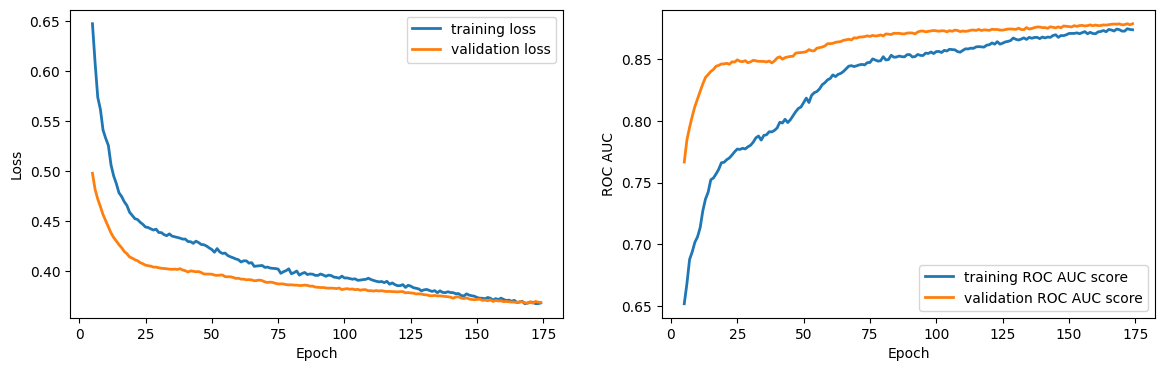

In [11]:
logs = pd.DataFrame(history.history)

plt.clf()
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(logs.loc[5:,"loss"], lw=2, label='training loss')
plt.plot(logs.loc[5:,"val_loss"], lw=2, label='validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(logs.loc[5:,"auc"], lw=2, label='training ROC AUC score')
plt.plot(logs.loc[5:,"val_auc"], lw=2, label='validation ROC AUC score')
plt.xlabel("Epoch")
plt.ylabel("ROC AUC")
plt.legend(loc='lower right')
plt.show()

In [12]:
positive_label = 1
negative_label = 0
preds_Xtest = rounded_model.predict(X_test.apply(lambda x: label_encoder_dict[x.name].transform(x)).values)

212/212 [==============================] - 0s 1ms/step


In [13]:
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds_Xtest))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      5102
           1       0.75      0.53      0.62      1681

    accuracy                           0.84      6783
   macro avg       0.81      0.74      0.76      6783
weighted avg       0.83      0.84      0.83      6783



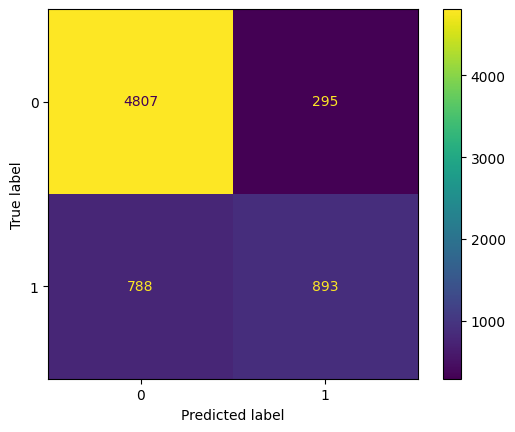

In [14]:
conf_matrix = confusion_matrix(y_test, preds_Xtest)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

# Rules

In [15]:
# ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness_NN(
#     X_test,
#     model=rounded_model,
#     label_encoder_dict=label_encoder_dict,
#     sensitive_attribute='sex',
#     freqitem_minsupp = 0.01,
#     missing_subgroup_val="Unknown",
#     drop_infeasible = True,
#     drop_above = True
# )

# print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
# rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

In [16]:
## Use this for loading rules from disk
rules_by_if = load_rules_by_if("rulesAdultFairTest-NN.data")
## Use this for saving rules on disk
# save_rules_by_if("rulesAdultFairTest-NN.data", rules_by_if)

In [17]:
num_features_ = ['education-num', 'capital-gain', 'capital-loss']
cate_features_ = ['age', 'Workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
ord_features_ = ['hours-per-week']

feature_weights = {"race" : 100 , "sex": 100, "marital-status": 5, "relationship":5, "age": 10, "occupation": 4, "Workclass": 2, "native-country": 4,
                    "hours-per-week":2, "capital-gain": 1, "capital-loss":1, "education-num": 3}
features_with_binary_cost = cate_features
features_with_proportional_cost = num_features


comparators = facts.feature_change_builder(
    X_test,
    num_cols=features_with_proportional_cost,
    cate_cols=features_with_binary_cost,
    ord_cols=ord_features,
    feature_weights=feature_weights,
    num_normalization=True,
    feats_to_normalize = ["capital-gain","capital-loss"]
)
params = ParameterProxy(featureChanges=comparators)

In [18]:
# rules_with_cumulative = facts.cum_corr_costs_all_NN(rules_by_if, X_test, rounded_model, label_encoder_dict,sensitive_attribute="sex", params=params)

In [19]:
## Use this for loading rules from disk
rules_with_cumulative = load_rules_by_if("rulesAdultFairTest-NN_cumulative.data")

## Use this for saving rules on disk
# save_rules_by_if("rulesAdultFairTest-NN_cumulative.data", rules_with_cumulative)

In [20]:
rules_with_atomic_correctness = rules_by_if
rules_with_cumulative_correctness = rules_with_cumulative

In [21]:
feature_weights = {"race" : 100 , "sex": 100, "marital-status": 5, "relationship":5, "age": 10, "occupation": 4, "Workclass": 2, "native-country": 4,
                    "hours-per-week":2, "capital-gain": 1, "capital-loss":1, "education-num": 3}
features_with_binary_cost = cate_features
features_with_proportional_cost = num_features


comparators = facts.feature_change_builder(
    X,
    num_cols=features_with_proportional_cost,
    cate_cols=features_with_binary_cost,
    ord_cols=ord_features,
    feature_weights=feature_weights,
    num_normalization=True,
    feats_to_normalize = ["capital-gain","capital-loss"]
)
params = ParameterProxy(featureChanges=comparators)

facts.update_costs_cumulative(rules_with_cumulative_correctness, params)

# Macro Viewpoint

## Equal Cost of Effectiveness (Macro)

In [22]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_with_atomic_correctness,
    metric="min-above-thr",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=top_count,
    cor_threshold=0.7,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",        
        "remove-fair-rules",
        "keep-only-min-change"
    ],
    params=params
)

print_recourse_report(
    top_rules,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    metric_name = 'Equal Cost of Effectiveness (Macro) (threshold = 0.7)'
)

If Workclass =  Self-emp-not-inc, capital-gain = 0:
	Protected Subgroup ' Male', 10.14% covered
		Make Workclass =  Private, capital-gain = 7298 with effectiveness 73.77%.
		Aggregate cost of the above recourses = 2.07
	Protected Subgroup ' Female', 3.83% covered
		Make Workclass =  Private, capital-gain = 99999 with effectiveness 70.13%.
		Aggregate cost of the above recourses = 3.00
	Bias against  Female due to Equal Cost of Effectiveness (Macro) (threshold = 0.7). Unfairness score = 0.93.
If Workclass =  Self-emp-not-inc, capital-gain = 0, capital-loss = 0:
	Protected Subgroup ' Male', 9.97% covered
		Make Workclass =  Private, capital-gain = 7298 with effectiveness 74.00%.
		Aggregate cost of the above recourses = 2.07
	Protected Subgroup ' Female', 3.83% covered
		Make Workclass =  Private, capital-gain = 99999 with effectiveness 70.13%.
		Aggregate cost of the above recourses = 3.00
	Bias against  Female due to Equal Cost of Effectiveness (Macro) (threshold = 0.7). Unfairness sco

## Equal Choice for Recourse(Macro)

In [23]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_with_atomic_correctness,
    metric="num-above-thr",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=top_count,
    cor_threshold=0.7,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",
        "remove-fair-rules"
    ],
    params=params
)

print_recourse_report(
    top_rules,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    metric_name = 'Equal Choice for Recourse(Macro) (threshold = 0.7)'
)

If capital-gain = 0, hours-per-week = BrainDrain:
	Protected Subgroup ' Male', 8.64% covered
		Make capital-gain = 15024, hours-per-week = OverTime with effectiveness 87.31%.
		Make capital-gain = 7688, hours-per-week = FullTime with effectiveness 75.00%.
		Make capital-gain = 15024, hours-per-week = FullTime with effectiveness 86.15%.
		Make capital-gain = 7298, hours-per-week = FullTime with effectiveness 70.38%.
		Make capital-gain = 7688, hours-per-week = OverTime with effectiveness 78.46%.
		Aggregate cost of the above recourses = -5.00
	Protected Subgroup ' Female', 3.43% covered
		No recourses for this subgroup!
		Aggregate cost of the above recourses = 0.00
	Bias against  Female due to Equal Choice for Recourse(Macro) (threshold = 0.7). Unfairness score = 5.
If capital-gain = 0, capital-loss = 0, hours-per-week = BrainDrain:
	Protected Subgroup ' Male', 8.21% covered
		Make capital-gain = 15024, hours-per-week = OverTime with effectiveness 87.45%.
		Make capital-gain = 7688, ho

# Micro Viewpoint

##  Equal Conditional Mean Recourse

In [24]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative_correctness,
    metric="fairness-of-mean-recourse-conditional",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=top_count,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules"
    ],
    params=params
)

print_recourse_report_cumulative(
    top_rules,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    metric_name = 'Equal Conditional Mean Recourse'
)

If marital-status =  Never-married, race =  White:
	Protected Subgroup ' Male', 33.77% covered
		Make marital-status =  Married-civ-spouse with effectiveness 0.41% and counterfactual cost = 5.
		Make marital-status =  Divorced with effectiveness 0.41% and counterfactual cost = 5.
		Make marital-status =  Married-civ-spouse, race =  Black with effectiveness 0.41% and counterfactual cost = 105.
		Make marital-status =  Married-civ-spouse, race =  Asian-Pac-Islander with effectiveness 0.41% and counterfactual cost = 105.
		Aggregate cost of the above recourses = 5.00
	Protected Subgroup ' Female', 37.01% covered
		Make marital-status =  Married-civ-spouse with effectiveness 0.00% and counterfactual cost = 5.
		Make marital-status =  Divorced with effectiveness 0.00% and counterfactual cost = 5.
		Make marital-status =  Married-civ-spouse, race =  Black with effectiveness 0.00% and counterfactual cost = 105.
		Make marital-status =  Married-civ-spouse, race =  Asian-Pac-Islander with effec

## Equal Cost of Effectiveness (Micro)

In [25]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative_correctness,
    metric="min-above-corr",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=top_count,
    cor_threshold = 0.7,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules",
        "keep-cheap-rules-above-thr-cor",
        
    ],
    params=params
)

print_recourse_report_cumulative(
    top_rules,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    metric_name = 'Equal Cost of Effectiveness (Micro) (threshold = 0.7)'
)

If age = (26.0, 34.0], education-num = 13, relationship =  Not-in-family:
	Protected Subgroup ' Male', 2.09% covered
		Make relationship =  Married with effectiveness 18.33% and counterfactual cost = 5.
		Make education-num = 14, relationship =  Married with effectiveness 70.00% and counterfactual cost = 8.
		Aggregate cost of the above recourses = 8.00
	Protected Subgroup ' Female', 2.44% covered
		Make relationship =  Married with effectiveness 6.38% and counterfactual cost = 5.
		Make education-num = 14, relationship =  Married with effectiveness 27.66% and counterfactual cost = 8.
		Make age = (41.0, 50.0], relationship =  Married with effectiveness 78.72% and counterfactual cost = 15.
		Aggregate cost of the above recourses = 15.00
	Bias against  Female due to Equal Cost of Effectiveness (Micro) (threshold = 0.7). Unfairness score = 7.
If age = (26.0, 34.0], education-num = 13, marital-status =  Never-married, relationship =  Not-in-family:
	Protected Subgroup ' Male', 1.96% cover

## Equal Effectiveness

In [26]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative_correctness,
    metric="total-correctness",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=top_count,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules",
    ],
    params=params
)

print_recourse_report_cumulative(
    top_rules,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    correctness_metric=True,
    metric_name = 'Equal Effectiveness'
)

If Workclass =  Private, capital-loss = 0, education-num = 13, relationship =  Own-child:
	Protected Subgroup ' Male', 1.33% covered
		Make relationship =  Married with effectiveness 5.00% and counterfactual cost = 5.0.
		Make Workclass =  Self-emp-not-inc, relationship =  Married with effectiveness 5.00% and counterfactual cost = 7.0.
		Make Workclass =  Self-emp-inc, relationship =  Married with effectiveness 5.00% and counterfactual cost = 7.0.
		Make Workclass =  Local-gov, relationship =  Married with effectiveness 25.00% and counterfactual cost = 7.0.
		Make education-num = 14, relationship =  Married with effectiveness 32.50% and counterfactual cost = 8.0.
		Make Workclass =  Local-gov, education-num = 14, relationship =  Married with effectiveness 85.00% and counterfactual cost = 10.0.
		Make Workclass =  State-gov, education-num = 14, relationship =  Married with effectiveness 85.00% and counterfactual cost = 10.0.
		Make education-num = 15, relationship =  Married with effect

## Fair Effectiveness-Cost Trade-Off

In [27]:
# taken from the other notebooks
affected_pop_sizes = {" Male": 6732, " Female": 4106}

top_rules,unfairness = facts.select_rules_subset_KStest(
    rules_with_cumulative_correctness,
    affected_pop_sizes,
    top_count=top_count
)

print_recourse_report_KStest_cumulative(
    top_rules,
    population_sizes=affected_pop_sizes,
    unfairness = unfairness,
    show_then_costs=True,
    metric_name = 'Fair Effectiveness-Cost Trade-Off'
    # show_cumulative_plots=True
)

If capital-gain = 0, capital-loss = 0:
	Protected Subgroup ' Male', 91.59% covered out of 6732
		Make capital-gain = 5178 with effectiveness 57.65% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 84.44% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 87.96% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 99.22% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 99.22% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 99.22% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 99.22% and counterfactual cost = 0.45.
		Make capital-gain = 99999 with effectiveness 99.28% and counterfactual cost = 1.0.
	Protected Subgroup ' Female', 93.33% covered out of 4106
		Make capital-gain = 5178 with effectiveness 21.25% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 62.18% and counterfactual cost = 0.

## Equal Effectiveness within Budget (Micro)

In [28]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative_correctness,
    metric="max-upto-cost",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=top_count,
    cost_threshold = cost_budget,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules",
        "remove-above-thr-cost"
    ],
    params=params
)

print_recourse_report_cumulative(
    top_rules,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    correctness_metric = True,
    metric_name = 'Equal Effectiveness within Budget (Micro)'
)

If Workclass =  Private, age = (26.0, 34.0], capital-gain = 0, capital-loss = 0, education-num = 13, native-country =  United-States, race =  White, relationship =  Not-in-family:
	Protected Subgroup ' Male', 1.43% covered
		Make relationship =  Married with effectiveness 14.71% and counterfactual cost = 5.0.
		Make education-num = 14, relationship =  Married with effectiveness 100.00% and counterfactual cost = 8.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup ' Female', 1.69% covered
		Make relationship =  Married with effectiveness 0.00% and counterfactual cost = 5.0.
		Make education-num = 14, relationship =  Married with effectiveness 4.17% and counterfactual cost = 8.0.
		Aggregate cost of the above recourses = 0.04
	Bias against  Female due to Equal Effectiveness within Budget (Micro). Unfairness score = 0.958.
If age = (26.0, 34.0], capital-gain = 0, capital-loss = 0, education-num = 13, native-country =  United-States, race =  White, relationship =  Not-in

## Get ranking of subgroups based on metrics

In [29]:
from facts.fairness_metrics_aggr import make_table, auto_budget_calculation

In [30]:
rules_with_both = {}
for ifc, all_thens in rules_with_cumulative_correctness.items():
    new_all_thens = {}
    for sg, (cov, thens_cum) in all_thens.items():
        thens_atom = rules_with_atomic_correctness[ifc][sg][1]
        thens_atom_dict = {then: atom_cor for then, atom_cor in thens_atom}
        new_all_thens[sg] = (cov, [(then, thens_atom_dict[then], cumcor) for then, cumcor, _cost in thens_cum])
    rules_with_both[ifc] = new_all_thens

In [31]:
budgets = auto_budget_calculation(rules_with_cumulative_correctness, cor_thres=0.5, percentiles=[0.3, 0.6, 0.9])

df = make_table(
    rules_with_both,
    sensitive_attribute_vals=[" Male", " Female"],
    effectiveness_thresholds=[0.3, 0.7],
    cost_budgets=budgets,
    params=params
)
# dropping 'weighted-average' and 'mean-cost-cinf'
df.drop(['weighted-average', 'mean-cost-cinf'], axis=1, inplace=True)

In [32]:
df[('Fair Effectiveness-Cost Trade-Off', 'bias')] = df[('Fair Effectiveness-Cost Trade-Off', 'bias')].str.replace(" ", "")

In [33]:
#table of differences between Male and Female for each metric

diff = get_diff_table(df, sensitive_attribute_vals=[" Male", " Female"], with_abs = True)
diff = diff.set_index('subgroup')
ranked = diff.drop(columns=[('Fair Effectiveness-Cost Trade-Off','bias')]).mask(diff == 0).rank(ascending = False,axis=0,method='dense')
ranked = ranked.replace(np.nan,"Fair")

In [34]:
rev_bias_metrics = ['Equal Effectiveness', 'Equal Effectiveness within Budget']
comb_df = get_comb_df(df, ranked, diff, rev_bias_metrics, sensitive_attribute_vals=[" Male", " Female"])
diff_real_val, _, = get_diff_real_diff_drop(df, diff, sensitive_attribute_vals=[" Male", " Female"])
analysis_df,rank_analysis_df = get_analysis_dfs(comb_df,diff_real_val, rev_bias_metrics, ranked, sensitive_attribute_vals=["Male", "Female"], percentage=0.1)

In [35]:
comb_df.head()

(Equal Cost of Effectiveness(Macro), 0.3)  \
                                                                                       rank   
subgroup                                                                                      
capital-loss = 0                                                                       Fair   
capital-gain = 0                                                                       13.0   
capital-gain = 0, capital-loss = 0                                                     13.0   
capital-loss = 0, native-country =  United-States                                       1.0   
race =  White                                                                          Fair   

                                                                        \
                                                    score bias against   
subgroup                                                                 
capital-loss = 0                                   0.0000         Fair   
capital-gain = 0                                   0.0212       Female   
capital-gain = 0, capital-loss = 0                 0.0212       Female   
capital-loss = 0, native-country =  United-States     inf       Female   
race =  White                                      0.0000         Fair   

                                                  (Equal Cost of Effectiveness(Macro), 0.7)  \
                                                                                       rank   
subgroup                                                                                      
capital-loss = 0                                                                       Fair   
capital-gain = 0                                                                        1.0   
capital-gain = 0, capital-loss = 0                                                      1.0   
capital-loss = 0, native-country =  United-States                                      Fair   
race =  White                                                                          Fair   

                                                                      \
                                                  score bias against   
subgroup                                                               
capital-loss = 0                                    0.0         Fair   
capital-gain = 0                                    inf       Female   
capital-gain = 0, capital-loss = 0                  inf       Female   
capital-loss = 0, native-country =  United-States   0.0         Fair   
race =  White                                       0.0         Fair   

                                                  (Equal Choice for Recourse, 0.3)  \
                                                                              rank   
subgroup                                                                             
capital-loss = 0                                                              Fair   
capital-gain = 0                                                               5.0   
capital-gain = 0, capital-loss = 0                                             4.0   
capital-loss = 0, native-country =  United-States                              5.0   
race =  White                                                                 Fair   

                                                                      \
                                                  score bias against   
subgroup                                                               
capital-loss = 0                                    0.0         Fair   
capital-gain = 0                                    1.0       Female   
capital-gain = 0, capital-loss = 0                  2.0       Female   
capital-loss = 0, native-country =  United-States   1.0       Female   
race =  White                                       0.0         Fair   

                                                  (Equal Choice for Recourse, 0.7)  \
      

In [36]:
analysis_df

,Rank = 1 Count,Male bias against Count,Female bias against Count,Top 10% Male bias against Count,Top 10% Female bias against Count
"(Equal Cost of Effectiveness(Macro), 0.3)",91,55,154,1,19
"(Equal Cost of Effectiveness(Macro), 0.7)",410,61,374,12,31
"(Equal Choice for Recourse, 0.3)",2,111,181,6,23
"(Equal Choice for Recourse, 0.7)",6,84,374,3,42
Equal Effectiveness,1,1808,7164,6,891
"(Equal Effectiveness within Budget, 5.072980729807298)",1,796,4062,3,482
"(Equal Effectiveness within Budget, 10.0)",1,1343,6290,5,758
"(Equal Effectiveness within Budget, 15.076880768807689)",1,1543,6493,4,799
"(Equal Cost of Effectiveness(Micro), 0.3)",777,138,1270,18,122
"(Equal Cost of Effectiveness(Micro), 0.7)",203,7,648,4,61


In [37]:
rank_analysis_df

,"(Equal Cost of Effectiveness(Macro), 0.3)","(Equal Cost of Effectiveness(Macro), 0.7)","(Equal Choice for Recourse, 0.3)","(Equal Choice for Recourse, 0.7)",Equal Effectiveness,"(Equal Effectiveness within Budget, 5.072980729807298)","(Equal Effectiveness within Budget, 10.0)","(Equal Effectiveness within Budget, 15.076880768807689)","(Equal Cost of Effectiveness(Micro), 0.3)","(Equal Cost of Effectiveness(Micro), 0.7)",Equal(Conditional) Mean Recourse,"(Fair Effectiveness-Cost Trade-Off, value)"
"(Equal Cost of Effectiveness(Macro), 0.3)",1.0,6.5,4.3,5.9,3234.1,2290.3,3583.3,3500.4,25.3,19.3,2605.7,2352.5
"(Equal Cost of Effectiveness(Macro), 0.7)",24.4,1.0,5.8,4.2,5198.2,2814.2,4615.0,4707.5,31.1,20.5,3016.8,3093.1
"(Equal Choice for Recourse, 0.3)",1.0,7.0,1.0,6.0,6079.0,3584.0,5739.0,5994.0,32.0,7.0,2707.0,528.0
"(Equal Choice for Recourse, 0.7)",26.0,1.0,6.0,1.0,4532.7,2306.0,3907.0,4204.3,32.0,23.0,2579.7,3127.0
Equal Effectiveness,26.0,7.0,6.0,6.0,1.0,3018.0,22.0,27.0,10.0,1.0,2157.0,87.0
"(Equal Effectiveness within Budget, 5.072980729807298)",26.0,7.0,6.0,6.0,3391.0,1.0,1626.0,1448.0,10.0,5.0,411.0,53.0
"(Equal Effectiveness within Budget, 10.0)",26.0,7.0,6.0,6.0,6496.0,739.0,1.0,5994.0,6.0,2.0,87.0,1.0
"(Equal Effectiveness within Budget, 15.076880768807689)",26.0,7.0,6.0,6.0,1531.0,3584.0,5739.0,1.0,10.0,5.0,381.0,2.0
"(Equal Cost of Effectiveness(Micro), 0.3)",25.4,7.0,6.0,6.0,782.9,1823.1,1541.0,1219.1,1.0,22.4,1362.2,1142.3
"(Equal Cost of Effectiveness(Micro), 0.7)",26.0,6.9,6.0,6.0,499.4,1542.3,554.2,465.9,12.4,1.0,1440.0,549.8


In [38]:
# ranked_indexed = top_rank.set_index([top_rank.index, "subgroup"])
# ranked_fair = ranked_indexed == 'Fair'
# ranked_more_than_2000 = ranked_indexed.mask(ranked_indexed=='Fair') >= 1000
# new_rank = ranked_indexed[ranked_fair.apply(lambda row: row.sum() >=4 , axis=1) | ranked_more_than_2000.apply(lambda row : row.sum() >= 6,axis=1)]
# new_rank.head()

In [39]:
# sgs = [
#     ranked.iloc[9841].subgroup,
# ]

# rules_sgs_atomic = {ifc: rules_with_atomic_correctness[ifc] for ifc in sgs}
# rules_sgs_cumulative = {ifc: rules_with_cumulative_correctness[ifc] for ifc in sgs}

In [40]:
# df.iloc[4228].to_frame().T

In [41]:
# top_rules, subgroup_costs = facts.select_rules_subset(
#     rules_sgs_atomic,
#     metric="min-above-thr",
#     sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
#     cor_threshold=0.7,
#     filter_sequence = [
#         # "remove-contained",
#         "remove-below-thr",        
#         #"remove-fair-rules", 
#         "keep-only-min-change"
#     ],
#     params=params
# )

# print_recourse_report(
#     top_rules,
#     subgroup_costs=subgroup_costs,
#     show_subgroup_costs=True
# )

In [42]:
# top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
#     rules_sgs_cumulative,
#     metric="max-upto-cost",
#     sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
#     top_count=top_count,
#     cost_threshold = 10,
#     filter_sequence = [
#         # "remove-contained",
#         # "remove-fair-rules",
#         "keep-cheap-rules-above-thr-cor",
#         # "keep-only-min-change",
        
#     ],
#     params=params
# )

# print_recourse_report_cumulative(
#     top_rules,
#     subgroup_costs=subgroup_costs,
#     show_subgroup_costs=True,
#     show_then_costs=True,
#     correctness_metric=True
# )

In [43]:
max_ranks = get_map_metric_to_max_rank(ranked)
rank_divided = get_other_ranks_divided(rank_analysis_df, max_ranks)
print(rank_divided.to_latex())

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
{} &  (Equal Cost of Effectiveness(Macro), 0.3) &  (Equal Cost of Effectiveness(Macro), 0.7) &  (Equal Choice for Recourse, 0.3) &  (Equal Choice for Recourse, 0.7) &  Equal Effectiveness &  (Equal Effectiveness within Budget, 5.072980729807298) &  (Equal Effectiveness within Budget, 10.0) &  (Equal Effectiveness within Budget, 15.076880768807689) &  (Equal Cost of Effectiveness(Micro), 0.3) &  (Equal Cost of Effectiveness(Micro), 0.7) &  Equal(Conditional) Mean Recourse &  (Fair Effectiveness-Cost Trade-Off, value) \\
\midrule
(Equal Cost of Effectiveness(Macro), 0.3)          &                                        NaN &                                      0.929 &                             0.717 &                             0.983 &                0.498 &                                              0.639 &                                      0.624 &                                              0.584 &                                      

In [44]:
max_ranks

{('Equal Cost of Effectiveness(Macro)', 0.3): 25.0,
 ('Equal Cost of Effectiveness(Macro)', 0.7): 6.0,
 ('Equal Choice for Recourse', 0.3): 5.0,
 ('Equal Choice for Recourse', 0.7): 5.0,
 'Equal Effectiveness': 6495.0,
 ('Equal Effectiveness within Budget', 5.072980729807298): 3583.0,
 ('Equal Effectiveness within Budget', 10.0): 5738.0,
 ('Equal Effectiveness within Budget', 15.076880768807689): 5993.0,
 ('Equal Cost of Effectiveness(Micro)', 0.3): 31.0,
 ('Equal Cost of Effectiveness(Micro)', 0.7): 22.0,
 'Equal(Conditional) Mean Recourse': 3929.0,
 ('Fair Effectiveness-Cost Trade-Off', 'value'): 6993.0}

In [45]:
rank_divided

,"(Equal Cost of Effectiveness(Macro), 0.3)","(Equal Cost of Effectiveness(Macro), 0.7)","(Equal Choice for Recourse, 0.3)","(Equal Choice for Recourse, 0.7)",Equal Effectiveness,"(Equal Effectiveness within Budget, 5.072980729807298)","(Equal Effectiveness within Budget, 10.0)","(Equal Effectiveness within Budget, 15.076880768807689)","(Equal Cost of Effectiveness(Micro), 0.3)","(Equal Cost of Effectiveness(Micro), 0.7)",Equal(Conditional) Mean Recourse,"(Fair Effectiveness-Cost Trade-Off, value)"
"(Equal Cost of Effectiveness(Macro), 0.3)",NaN,0.929,0.717,0.983,0.498,0.639,0.624,0.584,0.791,0.839,0.663,0.336
"(Equal Cost of Effectiveness(Macro), 0.7)",0.938,NaN,0.967,0.700,0.800,0.785,0.804,0.785,0.972,0.891,0.768,0.442
"(Equal Choice for Recourse, 0.3)",0.038,1.000,NaN,1.000,0.936,1.000,1.000,1.000,1.000,0.304,0.689,0.075
"(Equal Choice for Recourse, 0.7)",1.000,0.143,1.000,NaN,0.698,0.643,0.681,0.701,1.000,1.000,0.656,0.447
Equal Effectiveness,1.000,1.000,1.000,1.000,NaN,0.842,0.004,0.005,0.312,0.043,0.549,0.012
"(Equal Effectiveness within Budget, 5.072980729807298)",1.000,1.000,1.000,1.000,0.522,NaN,0.283,0.242,0.312,0.217,0.105,0.008
"(Equal Effectiveness within Budget, 10.0)",1.000,1.000,1.000,1.000,1.000,0.206,NaN,1.000,0.188,0.087,0.022,0.000
"(Equal Effectiveness within Budget, 15.076880768807689)",1.000,1.000,1.000,1.000,0.236,1.000,1.000,NaN,0.312,0.217,0.097,0.000
"(Equal Cost of Effectiveness(Micro), 0.3)",0.977,1.000,1.000,1.000,0.121,0.509,0.269,0.203,NaN,0.974,0.347,0.163
"(Equal Cost of Effectiveness(Micro), 0.7)",1.000,0.986,1.000,1.000,0.077,0.430,0.097,0.078,0.388,NaN,0.366,0.079
